In [273]:
import pandas as pd

df = pd.read_csv('BTC-AUD.csv')

df = df[['Date', 'Close']]

df['Date']



0       2014-09-17
1       2014-09-18
2       2014-09-19
3       2014-09-20
4       2014-09-21
           ...    
3426    2024-02-03
3427    2024-02-04
3428    2024-02-05
3429    2024-02-06
3430    2024-02-07
Name: Date, Length: 3431, dtype: object

In [274]:
import datetime

def str_to_datetime(target):
  split = target.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2003-05-12')
datetime_object



datetime.datetime(2003, 5, 12, 0, 0)

In [275]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      2014-09-17
1      2014-09-18
2      2014-09-19
3      2014-09-20
4      2014-09-21
          ...    
3426   2024-02-03
3427   2024-02-04
3428   2024-02-05
3429   2024-02-06
3430   2024-02-07
Name: Date, Length: 3431, dtype: datetime64[ns]

In [276]:
df.index = df.pop('Date')

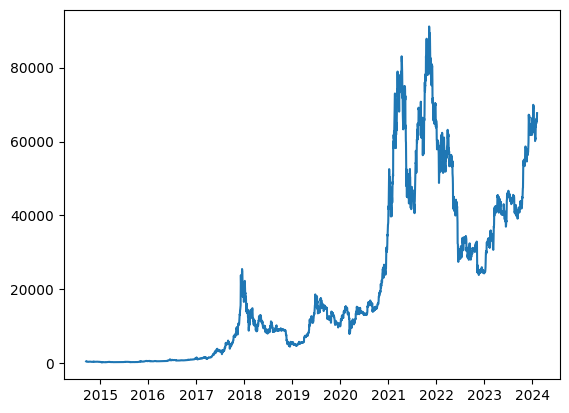

In [277]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])



In [278]:
import numpy as np

"""
From the start date to the last date, outputs a dataframe that shows
the data up to three days before the target date...

Essentially in the form: input and desired output...
"""
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df,
                                '2014-09-21',
                                '2016-01-07',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2014-09-21,472.650330,442.249359,458.053101,446.308197
1,2014-09-22,442.249359,458.053101,446.308197,453.077972
2,2014-09-23,458.053101,446.308197,453.077972,492.530487
3,2014-09-24,446.308197,453.077972,492.530487,477.765839
4,2014-09-25,453.077972,492.530487,477.765839,467.538330
...,...,...,...,...,...
469,2016-01-03,590.141174,595.304321,594.076172,590.512207
470,2016-01-04,595.304321,594.076172,590.512207,603.022827
471,2016-01-05,594.076172,590.512207,603.022827,603.464661
472,2016-01-06,590.512207,603.022827,603.464661,606.337463


In [279]:
#
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:,1:-1]
  # This is the format needed for LSTM:
  # number entries, timestep samples dimensions (3 in our case), and n.o. of features
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  # This is the target, ie the labels given to train the model...
  # It's like here are the input make some prediction, then check against the real value
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((474,), (474, 3, 1), (474,))

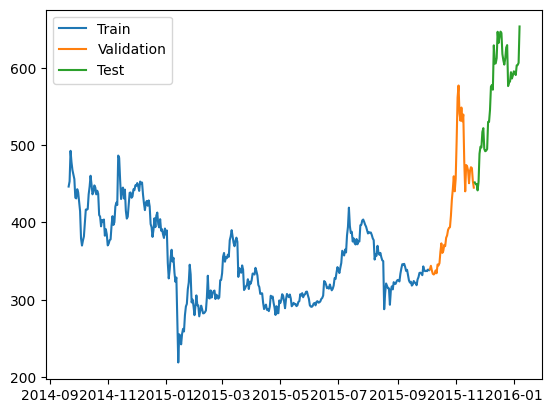

In [280]:
# Below is for testing performance -> we have up to 80 and 90% of the dates
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])


In [281]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Note that only 1 feature is needed, ie it is univariate
model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


Epoch 1/100
12/12 [==============================] - 3s 60ms/step - loss: 126000.0312 - mean_absolute_error: 350.9034 - val_loss: 184084.1562 - val_mean_absolute_error: 423.0124
Epoch 2/100
12/12 [==============================] - 0s 8ms/step - loss: 125369.5391 - mean_absolute_error: 350.0036 - val_loss: 183208.6875 - val_mean_absolute_error: 421.9742
Epoch 3/100
12/12 [==============================] - 0s 8ms/step - loss: 124387.8125 - mean_absolute_error: 348.5975 - val_loss: 181758.0000 - val_mean_absolute_error: 420.2553
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 123099.3594 - mean_absolute_error: 346.7419 - val_loss: 179697.6406 - val_mean_absolute_error: 417.7990
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 120831.6641 - mean_absolute_error: 343.4392 - val_loss: 175935.1719 - val_mean_absolute_error: 413.2481
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 116685.8594 - mean_absolute_error: 337.3

12/12 [==============================] - 0s 3ms/step


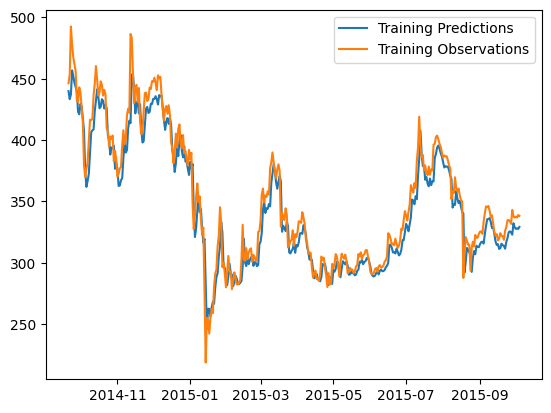

In [282]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 6ms/step


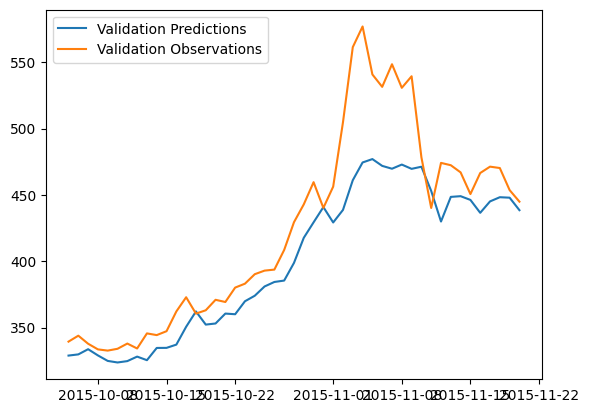

In [283]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])


2/2 [==============================] - 0s 5ms/step


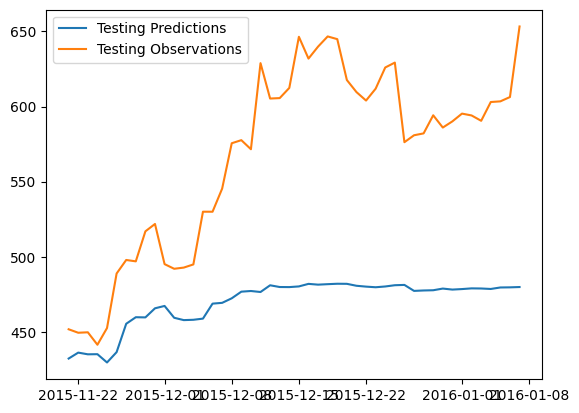

In [284]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

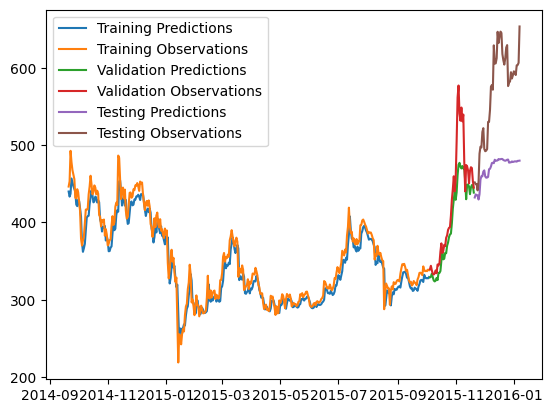

In [285]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [286]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 22ms/step


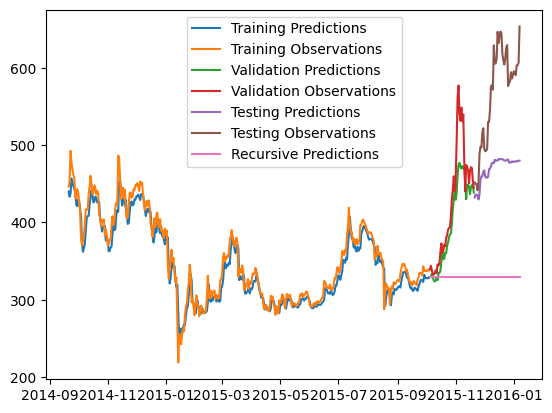

In [287]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])